# How to Train YOLOv9 on a Custom Dataset
---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/XHT2c8jT3Bc)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu May  2 16:31:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [ ]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 325 (delta 158), reused 155 (delta 155), pack-reused 109
Receiving objects: 100% (325/325), 2.23 MiB | 25.15 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [ ]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [ ]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [ ]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 May  2 16:33 .
drwxr-xr-x 1 root root      4096 May  2 16:33 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [ ]:
%cd {HOME}/yolov9

/content/yolov9


**NOTE:** In this tutorial, I will use the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on.

In [ ]:
import roboflow

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("nckh-qnyd1").project("traffic-sign-detection-2lmuq")
version = project.version(7)
dataset = version.download("yolov9")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov9 in progress : 85.0%
Version export complete for yolov9 format



Extracting Dataset Version Zip to Traffic-Sign-Detection-7 in yolov9:: 100%|██████████| 14616/14616 [00:03<00:00, 4758.12it/s]


## Train Custom Model

In [ ]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 15 --img 640 --device 0 --min-items 0 --close-mosaic 8 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-05-02 16:38:51.818368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 16:38:51.818438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 16:38:51.930291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 16:38:53.369942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=/content/weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/content/yolov9/Traffic-Sign-Detection-7/data.yaml, hyp=hyp.scratch-high.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, no

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [ ]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1714667934.ad86a369b89e.2867.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


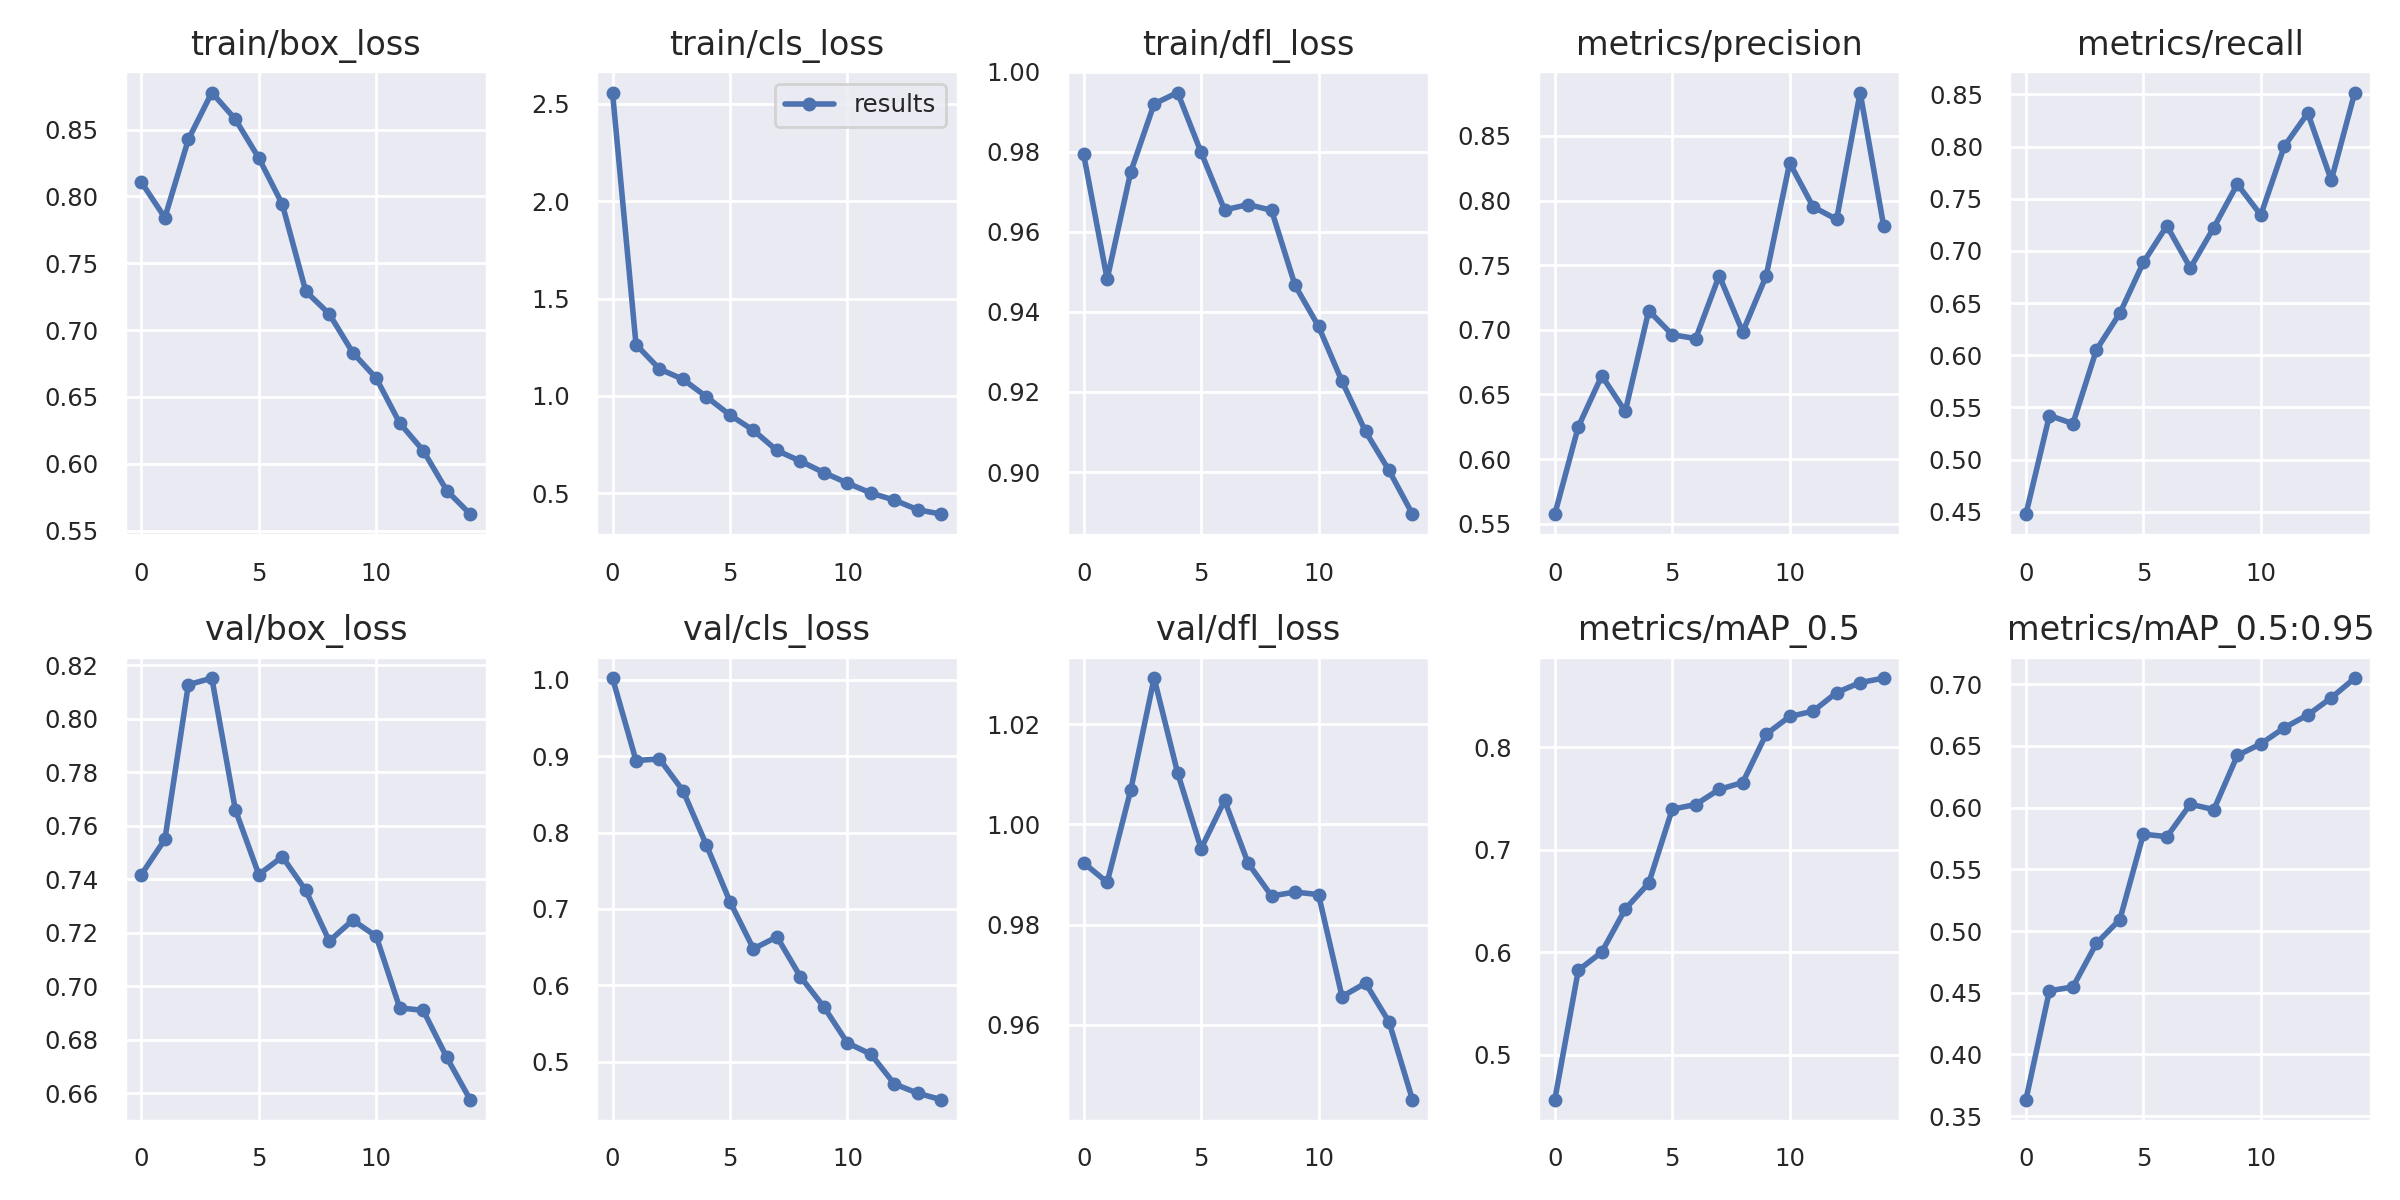

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

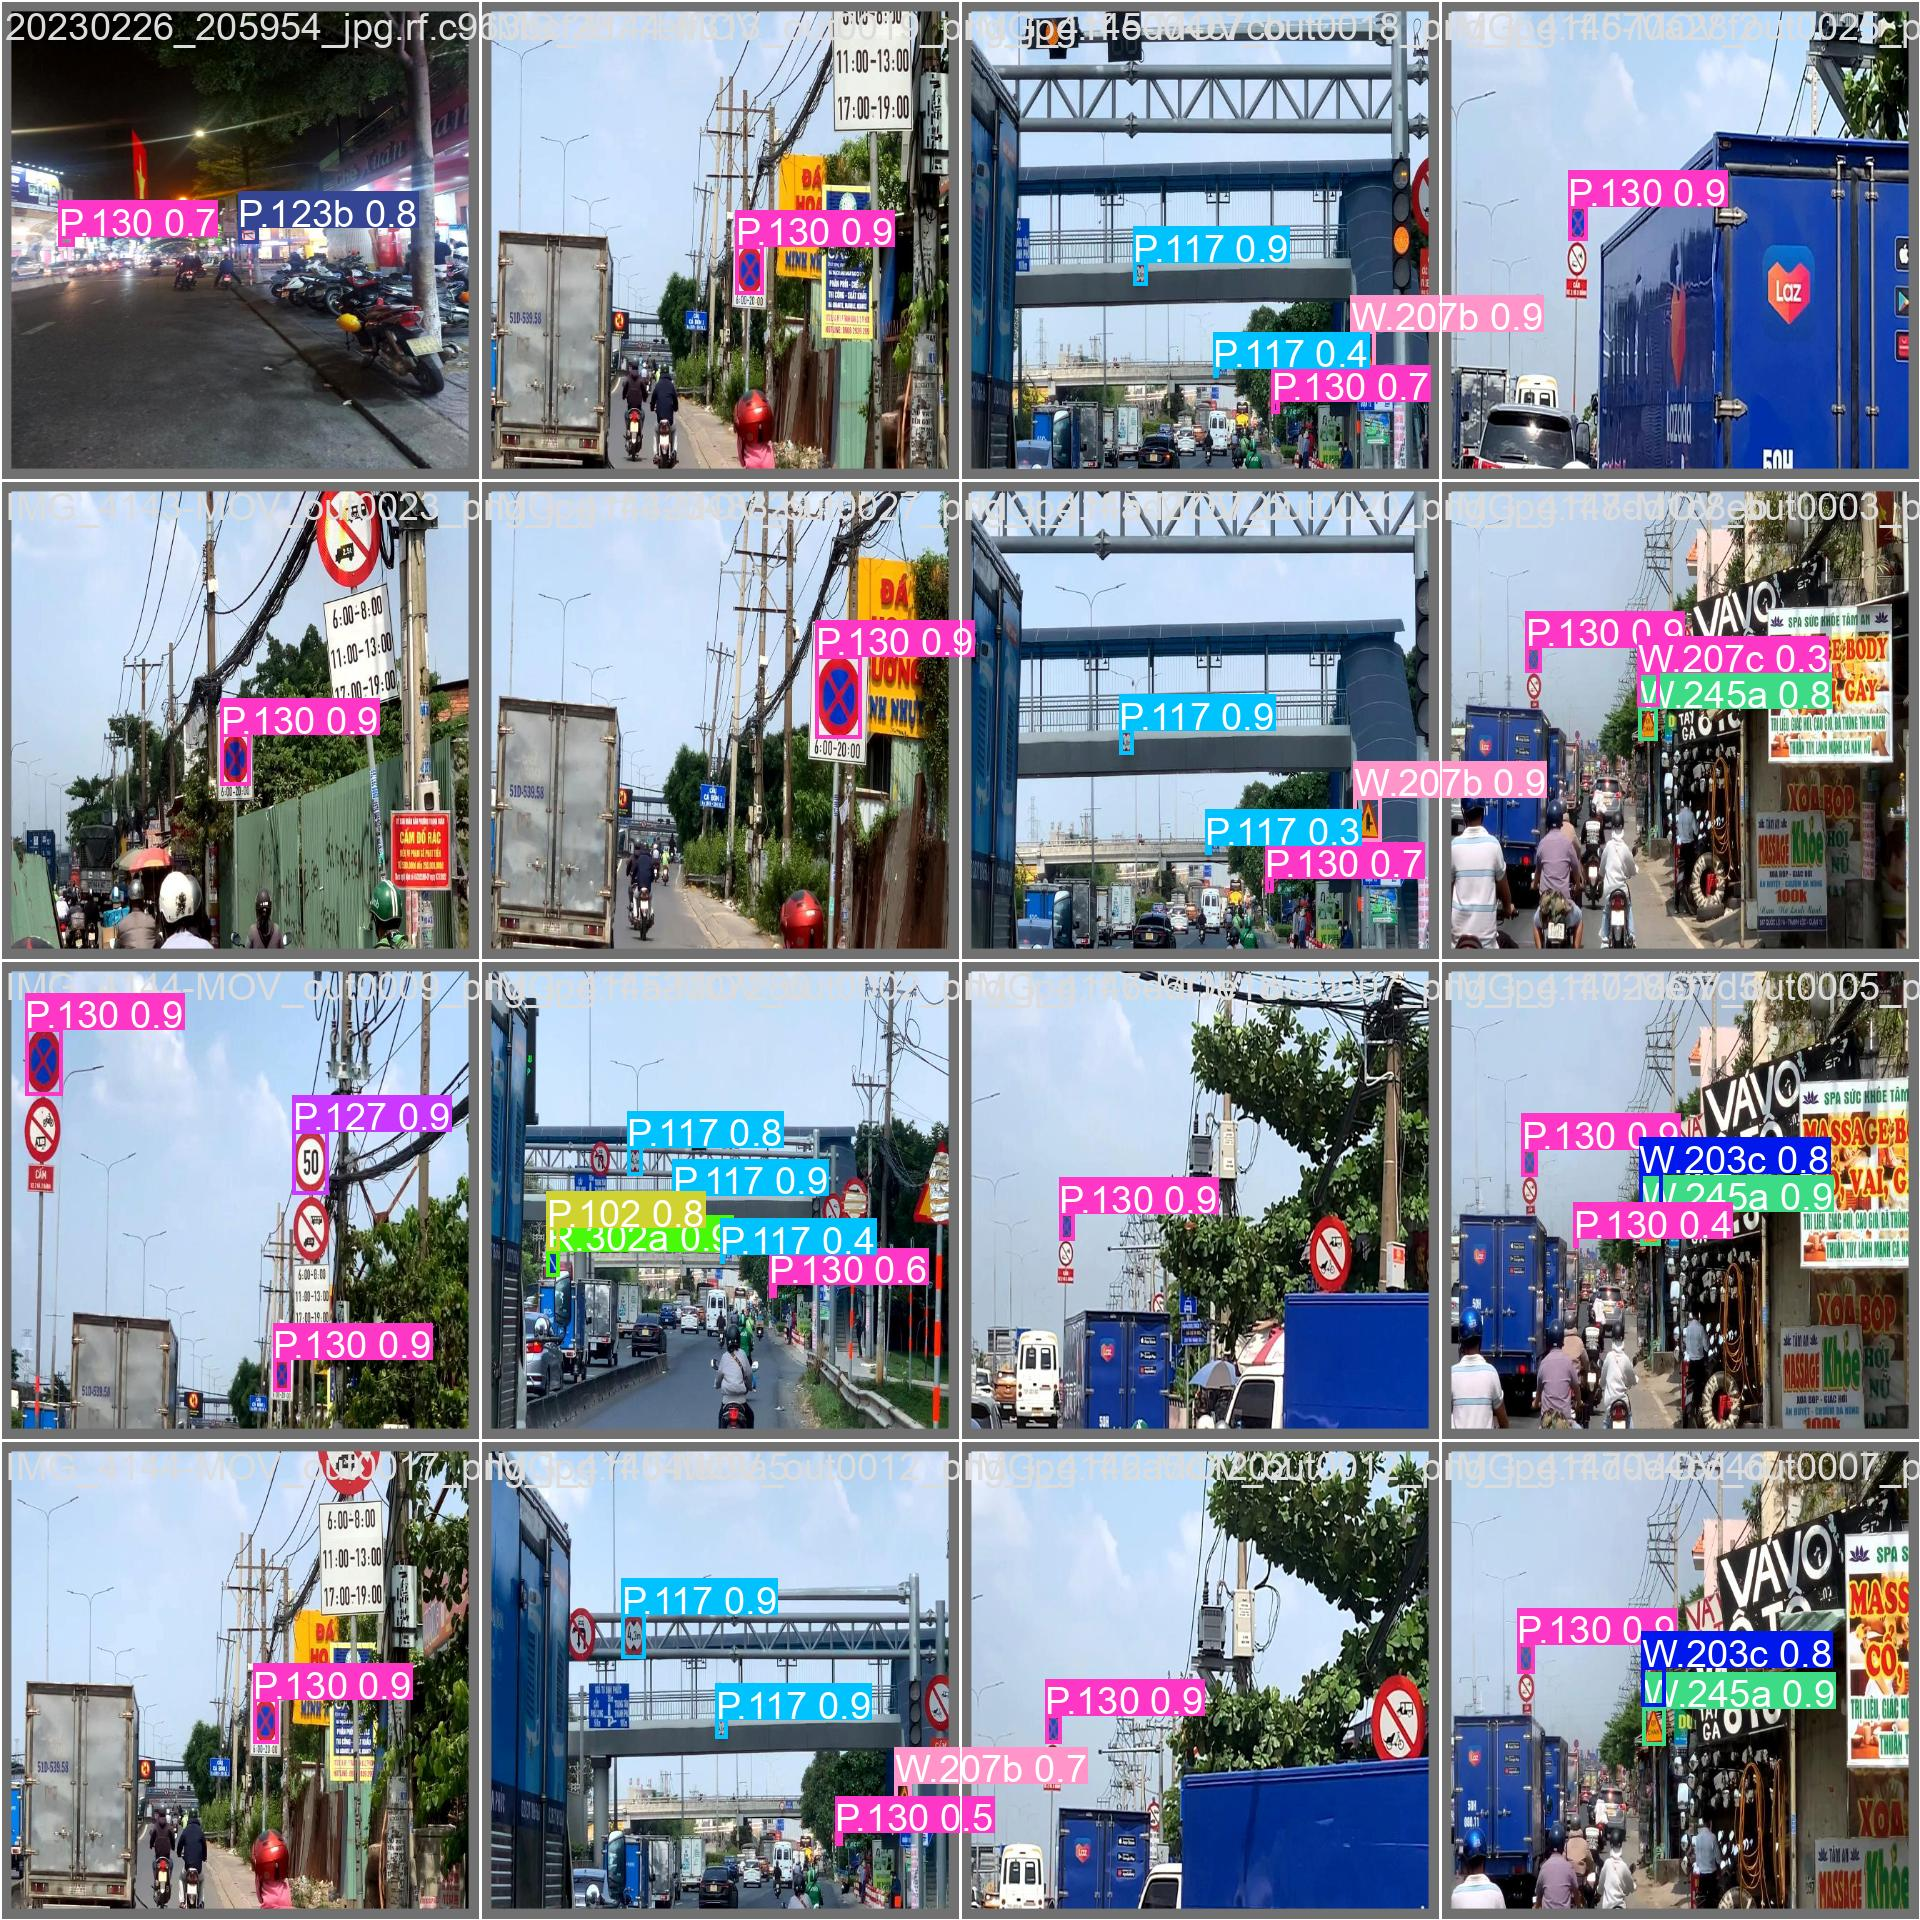

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [ ]:
!python detect.py --source /content/test.mp4 --weights '/content/yolov9/runs/train/exp/weights/best.pt' --device 0 --iou-thres 0.7


Streaming output truncated to the last 5000 lines.
video 1/1 (2863/7879) /content/test.mp4: 384x640 (no detections), 18.1ms
video 1/1 (2864/7879) /content/test.mp4: 384x640 (no detections), 18.6ms
video 1/1 (2865/7879) /content/test.mp4: 384x640 (no detections), 18.6ms
video 1/1 (2866/7879) /content/test.mp4: 384x640 (no detections), 18.4ms
video 1/1 (2867/7879) /content/test.mp4: 384x640 (no detections), 19.7ms
video 1/1 (2868/7879) /content/test.mp4: 384x640 (no detections), 21.0ms
video 1/1 (2869/7879) /content/test.mp4: 384x640 (no detections), 18.6ms
video 1/1 (2870/7879) /content/test.mp4: 384x640 (no detections), 18.0ms
video 1/1 (2871/7879) /content/test.mp4: 384x640 (no detections), 23.0ms
video 1/1 (2872/7879) /content/test.mp4: 384x640 (no detections), 18.0ms
video 1/1 (2873/7879) /content/test.mp4: 384x640 (no detections), 18.6ms
video 1/1 (2874/7879) /content/test.mp4: 384x640 (no detections), 19.0ms
video 1/1 (2875/7879) /content/test.mp4: 384x640 (no detections), 17.7ms


In [ ]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/Traffic-Sign-Detection-2/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25451052 parameters, 0 gradients, 102.7 GFLOPs
val: Scanning /content/yolov9/Traffic-Sign-Detection-2/valid/labels.cache... 617 images, 18 backgrounds, 0 corrupt: 100% 617/617 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 20/20 [00:27<00:00,  1.38s/it]
                   all        617       1214      0.841      0.869      0.919      0.741
Speed: 0.2ms pre-process, 33.

## Inference with Custom Model

In [ ]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source /content/yolov9/runs/detect/exp/test.mp4

Streaming output truncated to the last 5000 lines.
video 1/1 (2882/7879) /content/yolov9/runs/detect/exp/test.mp4: 736x1280 (no detections), 64.3ms
video 1/1 (2883/7879) /content/yolov9/runs/detect/exp/test.mp4: 736x1280 1 P.106a, 67.3ms
video 1/1 (2884/7879) /content/yolov9/runs/detect/exp/test.mp4: 736x1280 1 P.106a, 64.8ms
video 1/1 (2885/7879) /content/yolov9/runs/detect/exp/test.mp4: 736x1280 1 P.106a, 63.3ms
video 1/1 (2886/7879) /content/yolov9/runs/detect/exp/test.mp4: 736x1280 1 P.106a, 63.7ms
video 1/1 (2887/7879) /content/yolov9/runs/detect/exp/test.mp4: 736x1280 (no detections), 64.1ms
video 1/1 (2888/7879) /content/yolov9/runs/detect/exp/test.mp4: 736x1280 (no detections), 63.3ms
video 1/1 (2889/7879) /content/yolov9/runs/detect/exp/test.mp4: 736x1280 (no detections), 65.2ms
video 1/1 (2890/7879) /content/yolov9/runs/detect/exp/test.mp4: 736x1280 (no detections), 62.8ms
video 1/1 (2891/7879) /content/yolov9/runs/detect/exp/test.mp4: 736x1280 (no detections), 63.9ms
video 1

**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

In [ ]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))

**NOTE:** To deploy the model and display inference results, we will need two additional packages - [`inference`](https://pypi.org/project/inference) and [`supervision`](https://pypi.org/project/supervision). Let's install and import them!

In [ ]:
!pip install -q inference supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.1/356.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.7/239.7 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 940.0/940.0 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cv2
import random
import getpass

import supervision as sv

from inference import get_model

%matplotlib inline

**NOTE:** Before using your model in Inference, you first need to upload your weights to Roboflow Universe. Ensure to specify the correct `model_type` - `yolov9`, and that the project version matches the version of the dataset you used for training, denoted by `[1]`. In my case, it's `6`.

![YOLOv9 Benchmark](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/upload-roboflow-model.png)



In [ ]:
version.deploy(model_type="yolov9", model_path=f"{HOME}/yolov9/runs/train/exp")

View the status of your deployment at: https://app.roboflow.com/nckh-qnyd1/traffic-sign-detection-2lmuq/7
Share your model with the world at: https://universe.roboflow.com/nckh-qnyd1/traffic-sign-detection-2lmuq/model/7


**NOTE:** Now we can download our model anywhere using the assigned `model_id` denoted by `[2]`. In my case `football-players-detection-3zvbc/6`. To download the model you will need your [`ROBOFLOW_API_KEY`](https://docs.roboflow.com/api-reference/authentication).




In [ ]:
ROBOFLOW_API_KEY = getpass.getpass()

model = get_model(model_id="traffic-sign-detection-2lmuq/7", api_key=ROBOFLOW_API_KEY)

KeyboardInterrupt: Interrupted by user

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="A1nXgtiJdkVXD4GEHAet")
project = rf.workspace().project("traffic-sign-detection-2lmuq")
model = project.version("1").model

job_id, signed_url, expire_time = model.predict_video(
    "/content/test.mp4",
    fps=30,
    prediction_type="batch-video",
)

results = model.poll_until_video_results(job_id)

print(results)


loading Roboflow workspace...
loading Roboflow project...
Checking for video inference results for job 4b4948f1-3978-4be0-8dcc-06c93d4e1fcb every 60s
(0s): Checking for inference results
(60s): Checking for inference results
(120s): Checking for inference results
(180s): Checking for inference results
(240s): Checking for inference results
(300s): Checking for inference results
(360s): Checking for inference results
(420s): Checking for inference results
(480s): Checking for inference results
(540s): Checking for inference results
(600s): Checking for inference results
(660s): Checking for inference results
(720s): Checking for inference results
{'frame_offset': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152

**NOTE:** Let's pick random image from our test subset and detect objects using newly fine-tuned model.

In [ ]:
# import a utility function for loading Roboflow models
from inference import get_model

# define the image url to use for inference
image = "https://media.roboflow.com/inference/people-walking.jpg"

# load a pre-trained yolov8n model
model = get_model(model_id="yolov8n-640")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
results = model.infer(image)


In [ ]:
image_paths = sv.list_files_with_extensions(
    directory=f"{dataset.location}/test/images",
    extensions=['png', 'jpg', 'jpeg']
)
image_path = random.choice(image_paths)
image = cv2.imread(image_path)

result = model.infer(image, confidence=0.1)[0]
detections = sv.Detections.from_inference(result)

**NOTE:** Finally, let's use supervision and [annotate](https://supervision.roboflow.com/develop/annotators/) our results.

In [ ]:
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
bounding_box_annotator = sv.BoundingBoxAnnotator()

annotated_image = image.copy()
annotated_image = bounding_box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)